# Mesh2d refinement based on Gebco gridded samples

This is a brief introduction to the process of mesh refinement using gridded samples from Gebco global dataset. 

It is also an example of refining on spherical coordinates and saving results on spherical coordinates

At the very beginning, the necessary libraries have to be imported.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from meshkernel import GeometryList, GriddedSamples, MakeGridParameters, MeshKernel, MeshRefinementParameters, RefinementType

UGridPy is imported for writing the computed meshes to file

In [2]:
from ugrid import UGrid, UGridMesh2D

Define ugrid files attributes and conventions

In [3]:
attribute_dict = {
    "name": "WGS84",
    "epsg": np.array([4326], dtype=int),
    "grid_mapping_name": "latitude_longitude",
    "longitude_of_prime_meridian": np.array([0.0], dtype=float),
    "semi_major_axis": np.array([6378137.0], dtype=float),
    "semi_minor_axis": np.array([6356752.314245], dtype=float),
    "inverse_flattening": np.array([6356752.314245], dtype=float),
    "EPSG_code": "EPSG:4326",
    "value": "value is equal to EPSG code"}

conventions = {
    "institution": "Deltares",
    "references": "Unknown",
    "source": "Unknown Unknown. Model: Unknown",
    "history": "Created on 2017-11-27T18:05:09+0100, Unknown",
    "Conventions": "CF-1.6 UGRID-1.0/Deltares-0.8"}

## Create the starting mesh to refine

In [4]:
lon_min,lon_max = -1,-0.2
lat_min,lat_max = 49.1,49.6
lon_res,lat_res = 0.1,0.1
num_x = int(np.ceil((lon_max-lon_min)/lon_res))
num_y = int(np.ceil((lat_max-lat_min)/lat_res))

make_grid_parameters = MakeGridParameters()
make_grid_parameters.num_columns = num_x
make_grid_parameters.num_rows = num_y
make_grid_parameters.angle = 0.0
make_grid_parameters.origin_x = lon_min
make_grid_parameters.origin_y = lat_min
make_grid_parameters.block_size_x = 0.1
make_grid_parameters.block_size_y = 0.1

pol_x = np.empty(0, dtype=np.double)
pol_y = np.empty(0, dtype=np.double)
geometry_list = GeometryList(pol_x, pol_y)

mk = MeshKernel(is_geographic=True)
mk.curvilinear_make_uniform(make_grid_parameters, geometry_list)

Convert the curvilinear mesh to an unstructured mesh

In [5]:
mk.curvilinear_convert_to_mesh2d() 

Plot the mesh

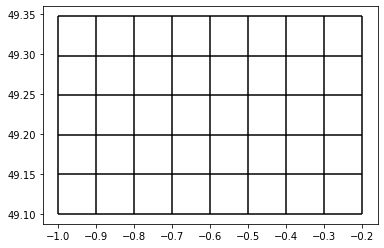

In [6]:
mesh2d = mk.mesh2d_get()
fig, ax = plt.subplots()
mesh2d.plot_edges(ax, color="black")

Write the intial mesh to file

In [7]:
mesh2d_ugrid = UGrid.from_meshkernel_mesh2d_to_ugrid_mesh2d(mesh2d=mesh2d, name="mesh2d", is_spherical=True)
with UGrid("./grid_net.nc", "w+") as ug:
    topology_id = ug.mesh2d_define(mesh2d_ugrid)
    ug.mesh2d_put(topology_id, mesh2d_ugrid)
    ug.variable_int_with_attributes_define("WGS84", attribute_dict)
    ug.attribute_global_define(conventions)

## Mesh refinement

Define a function for reading asc files

In [8]:
def read_asc_file(file_path):
    header = {}
    data = []

    with open(file_path, 'r') as file:
        for _ in range(6):
            line = file.readline().strip().split()
            header[line[0]] = float(line[1])
            
        for line in file:
            data_row = [float(value) for value in line.strip().split()]
            data.insert(0, data_row)
            
        data = np.array(data).flatten().astype(np.double)
        
    return header, data

Read the bathymetry from ASCII file

In [9]:
header, data = read_asc_file('./data_examples/gebco.asc')

In [10]:
gridded_samples = GriddedSamples(
    n_cols=int(header['ncols'])-1,
    n_rows=int(header['nrows'])-1,
    x_origin=header['xllcenter'],
    y_origin=header['yllcenter'],
    cell_size=header['cellsize'],
    values=data)

Define the mesh refinement parameters

In [11]:
refinement_params = MeshRefinementParameters(
    refine_intersected=False,
    use_mass_center_when_refining=False,
    min_edge_size=2.0,
    refinement_type=RefinementType.WAVE_COURANT,
    connect_hanging_nodes=True,
    account_for_samples_outside_face=False,
    max_refinement_iterations=5,
    smoothing_iterations=5,
    max_courant_time=120.0,
    directional_refinement=0)

Refinement can now be performed

In [12]:
mk.mesh2d_refine_based_on_gridded_samples(gridded_samples, refinement_params, True)

Visualize the refined mesh

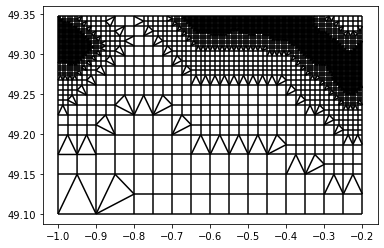

In [13]:
mesh2d_refined = mk.mesh2d_get()
fig, ax = plt.subplots()
mesh2d_refined.plot_edges(ax, color="black")

Save the refined mesh to file

In [14]:
mesh2d_refined_ugrid = UGrid.from_meshkernel_mesh2d_to_ugrid_mesh2d(mesh2d=mesh2d_refined, name="mesh2d", is_spherical=True)
with UGrid("./refinedgrid_net.nc", "w+") as ug:
    topology_id = ug.mesh2d_define(mesh2d_refined_ugrid)
    ug.mesh2d_put(topology_id, mesh2d_refined_ugrid)
    ug.variable_int_with_attributes_define("WGS84", attribute_dict)
    ug.attribute_global_define(conventions)